In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow import keras
import glob
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"blckiris","key":"878734b7281e8b3dbe3c8d90ea93519f"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 73% 11.0M/15.1M [00:00<00:00, 109MB/s]
100% 15.1M/15.1M [00:00<00:00, 135MB/s]


In [ ]:
! unzip "brain-mri-images-for-brain-tumor-detection.zip"

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [ ]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())

# List all files and directories in the current working directory
print("\nFiles and directories:")
for item in os.listdir(os.getcwd()):
    print(item)

Current working directory: /content

Files and directories:
.config
kaggle_data
no
kaggle.json
kaggle (1).json
brain-mri-images-for-brain-tumor-detection.zip
brain_tumor_dataset
yes
sample_data


In [ ]:
no = ['/content/brain_tumor_dataset/no']
yes = ['/content/brain_tumor_dataset/yes']
file_p = []
labels = []
dict_lists = [[Path(p) for p in dir_list] for dir_list in (no, yes)]
class_labels = ['no', 'yes']
data_full= yes + no
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        files = list(j.glob('*'))  # Convert to list
        file_p.extend([str(p) for p in files])
        labels.extend([class_labels[i]] * len(files))

failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [ ]:
df.head()

,filepaths,labels
0,/content/brain_tumor_dataset/yes/Y156.JPG,yes
1,/content/brain_tumor_dataset/no/No16.jpg,no
2,/content/brain_tumor_dataset/no/No17.jpg,no
3,/content/brain_tumor_dataset/yes/Y184.JPG,yes
4,/content/brain_tumor_dataset/yes/Y256.JPG,yes


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_val_data = train_test_split(df, test_size=0.4, random_state=42, stratify=df.labels)
test_data, val_data = train_test_split(test_val_data, test_size=0.375, random_state=42, stratify=test_val_data.labels)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (151, 2)
Test data shape: (63, 2)
Validation data shape: (39, 2)


In [ ]:
# Image augmentation function
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image


In [ ]:
# ImageDataGenerator with augmentation
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image),
    rotation_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Data generators
train = data_augmentation.flow_from_dataframe(
    dataframe=train_data,
    x_col="filepaths",
    y_col="labels",
    target_size=(256, 256),
    color_mode='rgb',
    class_mode="binary",
    batch_size=64,
    shuffle=True
)

test = data_augmentation.flow_from_dataframe(
    dataframe=test_data,
    x_col="filepaths",
    y_col="labels",
    target_size=(256, 256),
    color_mode='rgb',
    class_mode="binary",
    batch_size=64,
    shuffle=False
)

val = data_augmentation.flow_from_dataframe(
    dataframe=val_data,
    x_col="filepaths",
    y_col="labels",
    target_size=(256, 256),
    color_mode='rgb',
    class_mode="binary",
    batch_size=64,
    shuffle=False
)

Found 151 validated image filenames belonging to 2 classes.
Found 63 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


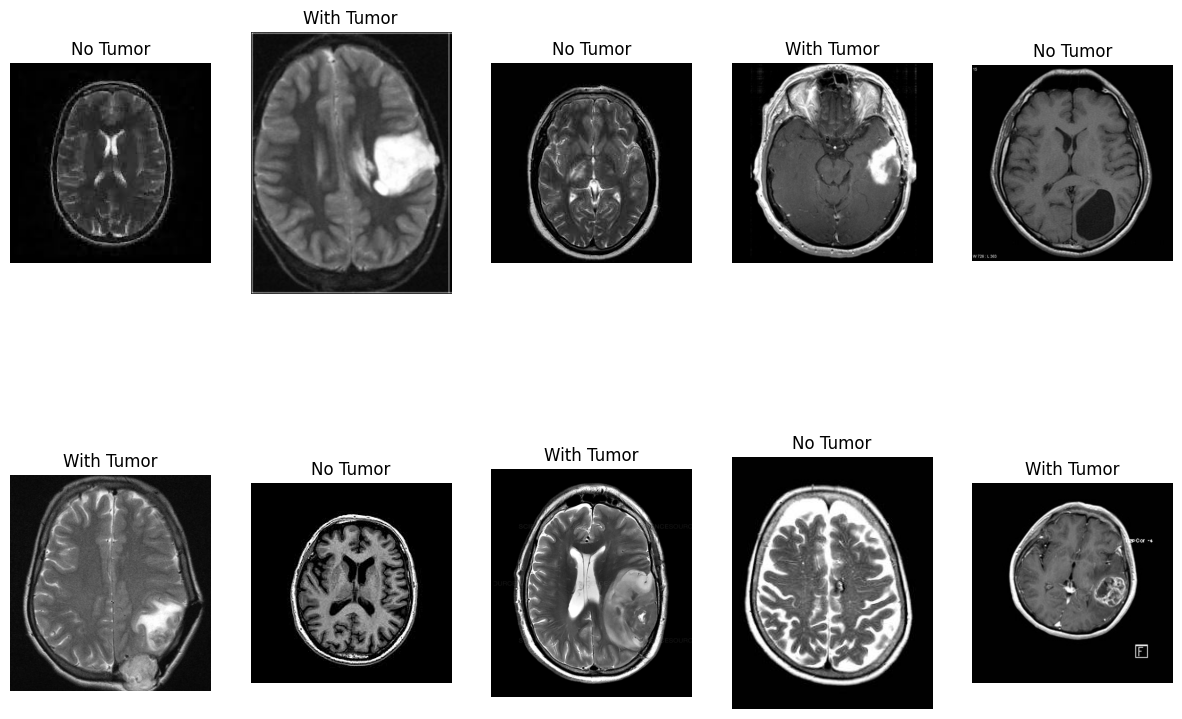

In [ ]:
# Define the number of images to display from each class
num_images_per_class = 5  # Reduced to 5 per class for better visualization

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_data[train_data['labels'] == label].index

    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)

    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = plt.imread(train_data.loc[idx, 'filepaths'])  # Load the image
        plt.imshow(img)

        # Assign labels based on class
        if label == 'no':
            my_label = 'No Tumor'
        elif label == 'yes':
            my_label = 'With Tumor'

        plt.xlabel(my_label)
        plt.title(my_label)
        plt.axis('off')
plt.show()

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomZoom(0.2)
])
callback = keras.callbacks.EarlyStopping(patience=50, monitor='loss')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
inputs = keras.Input(shape=(256, 256, 3))
# x = data_augmentation.flow(inputs)  # <-- Changed from data_augmentation(inputs) to this
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callback
callback = EarlyStopping(patience=50, monitor='loss')

# Fit the model
history = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[callback]
)

Epoch 1/20
3/3 [==============================] - 21s 5s/step - loss: 0.6789 - accuracy: 0.5828 - val_loss: 0.6822 - val_accuracy: 0.6154
Epoch 2/20
3/3 [==============================] - 17s 7s/step - loss: 0.7577 - accuracy: 0.6159 - val_loss: 0.6643 - val_accuracy: 0.6154
Epoch 3/20
3/3 [==============================] - 19s 5s/step - loss: 0.6465 - accuracy: 0.6159 - val_loss: 0.6822 - val_accuracy: 0.6154
Epoch 4/20
3/3 [==============================] - 18s 7s/step - loss: 0.6879 - accuracy: 0.6821 - val_loss: 0.6895 - val_accuracy: 0.6923
Epoch 5/20
3/3 [==============================] - 17s 7s/step - loss: 0.6877 - accuracy: 0.6424 - val_loss: 0.6840 - val_accuracy: 0.6154
Epoch 6/20
3/3 [==============================] - 18s 7s/step - loss: 0.6830 - accuracy: 0.6159 - val_loss: 0.6782 - val_accuracy: 0.6154
Epoch 7/20
3/3 [==============================] - 18s 7s/step - loss: 0.6767 - accuracy: 0.6159 - val_loss: 0.6682 - val_accuracy: 0.6154
Epoch 8/20
3/3 [==================

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                      

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 3s 3s/step - loss: 0.6472 - accuracy: 0.6032
Test Loss: 0.6471982598304749
Test Accuracy: 0.60317462682724


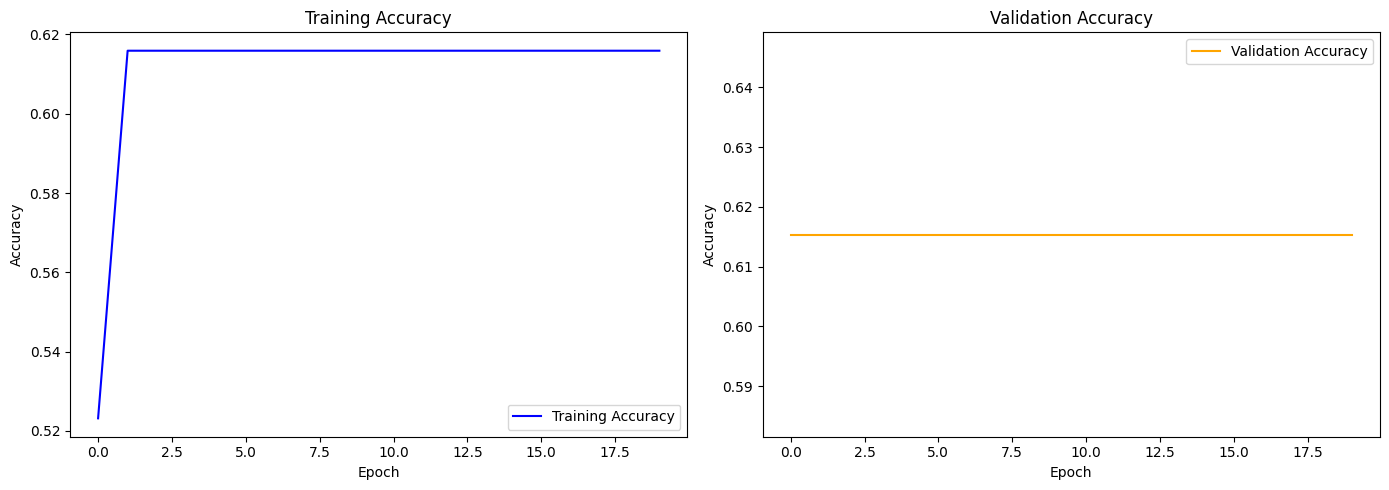

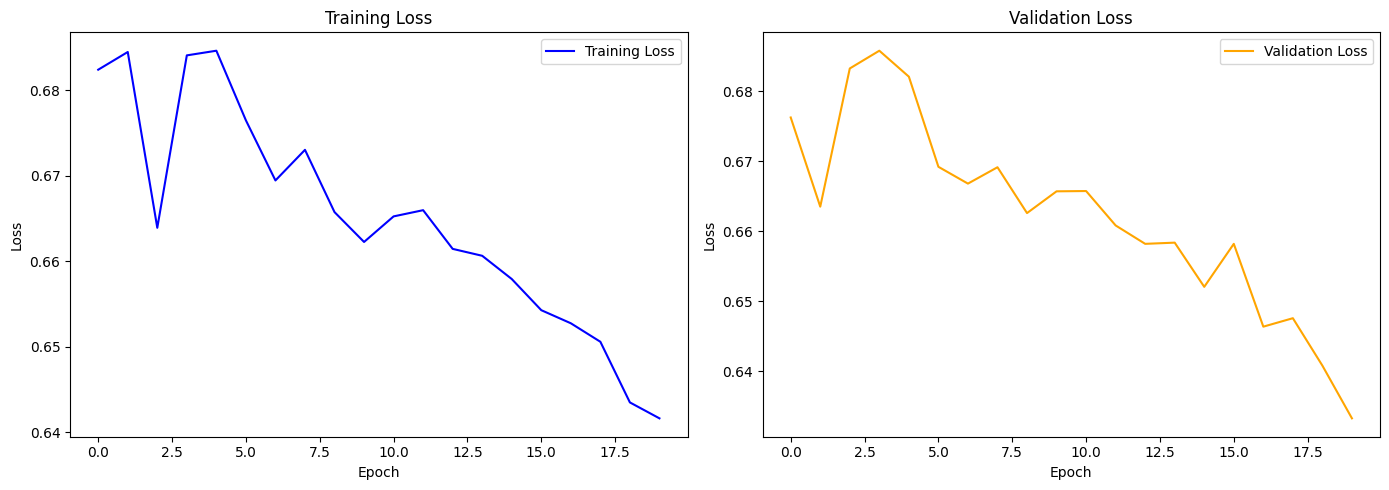

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

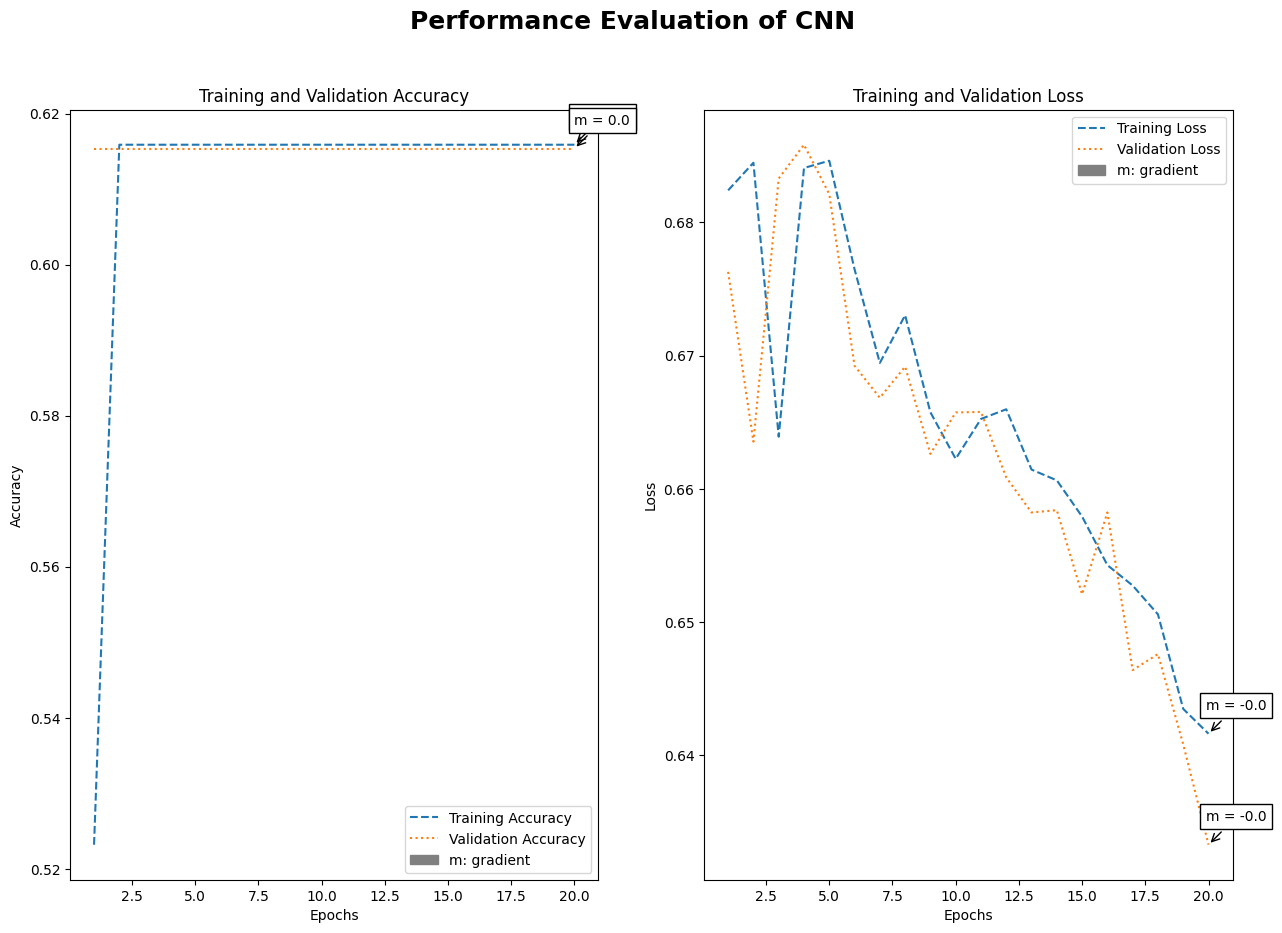

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, AnnotationBbox

# Get the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

def get_gradient(y_arr, epochs):
    return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

    def vis_sub_evaluation(n, metric_name, train_metric, val_metric):
        axs[n].plot(epochs, train_metric, label=f'Training {metric_name}', ls='--')
        axs[n].plot(epochs, val_metric, label=f'Validation {metric_name}', ls='dotted')
        axs[n].set_title(f'Training and Validation {metric_name}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(metric_name)
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(metric_arr):
            return AnnotationBbox(TextArea(f"m = {get_gradient(metric_arr, epochs)}"), (epochs[-1], metric_arr[-1]), xybox=(20, 20), xycoords='data', boxcoords="offset points", arrowprops=dict(arrowstyle="->"))

        axs[n].add_artist(annotate_box(train_metric))
        axs[n].add_artist(annotate_box(val_metric))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss)

    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

# Assuming you've already trained the model and have the history object
history_dict_1 = history.history
vis_evaluation(history_dict_1, 'CNN')

In [ ]:
# Define MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Get the output tensor from the base model
last_output = base_model.output

# Calculate the number of trainable parameters
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

# Print information about the model
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [ ]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Create the complete model by using the Model class
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    return model

# Create the transfer learning model
model = transfer_learning(last_output, base_model)

# Display the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming you have already initialized train and val data generators
# train and val are your ImageDataGenerators with shape (256, 256, 3)

# Define MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Get the output tensor from the base model
last_output = base_model.output

# Function to add custom layers for transfer learning
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Create the complete model by using the Model class
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    return model

# Create the transfer learning model
model = transfer_learning(last_output, base_model)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                    callbacks=[callback])

Epoch 1/10
3/3 [==============================] - 24s 6s/step - loss: 4.3623 - accuracy: 0.6490 - val_loss: 4.7591 - val_accuracy: 0.5897
Epoch 2/10
3/3 [==============================] - 20s 7s/step - loss: 3.7038 - accuracy: 0.7682 - val_loss: 4.3692 - val_accuracy: 0.7179
Epoch 3/10
3/3 [==============================] - 18s 7s/step - loss: 3.1635 - accuracy: 0.8013 - val_loss: 4.2152 - val_accuracy: 0.8205
Epoch 4/10
3/3 [==============================] - 17s 7s/step - loss: 1.8184 - accuracy: 0.8543 - val_loss: 3.0990 - val_accuracy: 0.7436
Epoch 5/10
3/3 [==============================] - 20s 8s/step - loss: 1.8986 - accuracy: 0.8411 - val_loss: 2.1266 - val_accuracy: 0.7692
Epoch 6/10
3/3 [==============================] - 17s 7s/step - loss: 1.0353 - accuracy: 0.9205 - val_loss: 1.8343 - val_accuracy: 0.8205
Epoch 7/10
3/3 [==============================] - 18s 7s/step - loss: 0.5147 - accuracy: 0.9272 - val_loss: 2.1216 - val_accuracy: 0.7692
Epoch 8/10
3/3 [==================

In [ ]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1/1 [==============================] - 4s 4s/step - loss: 1.7660 - accuracy: 0.8205
Validation Loss: 1.7660082578659058
Validation Accuracy: 0.8205128312110901


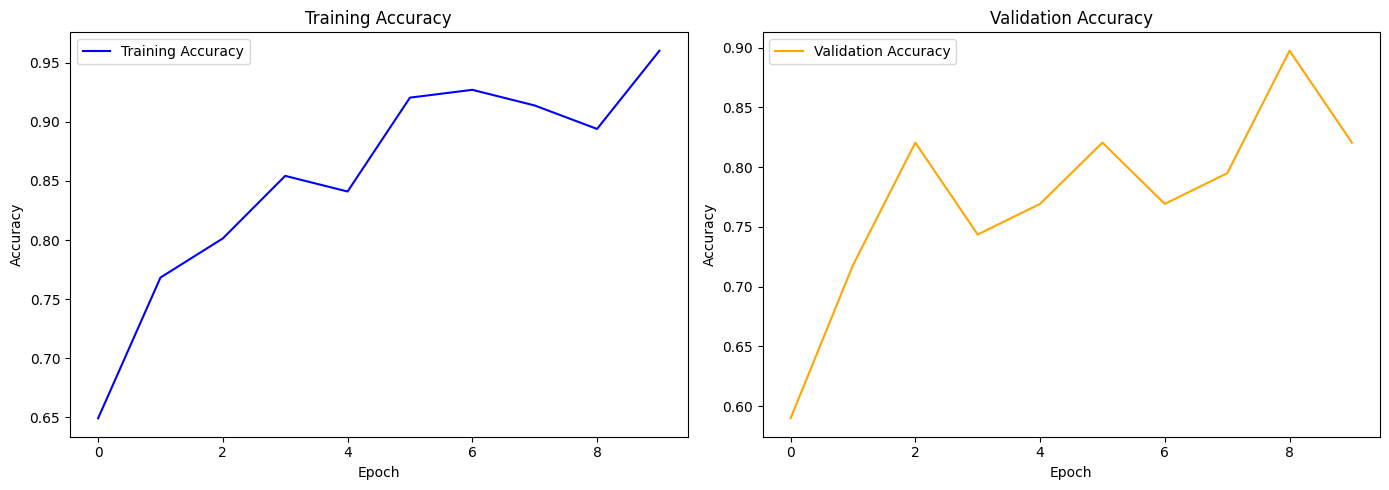

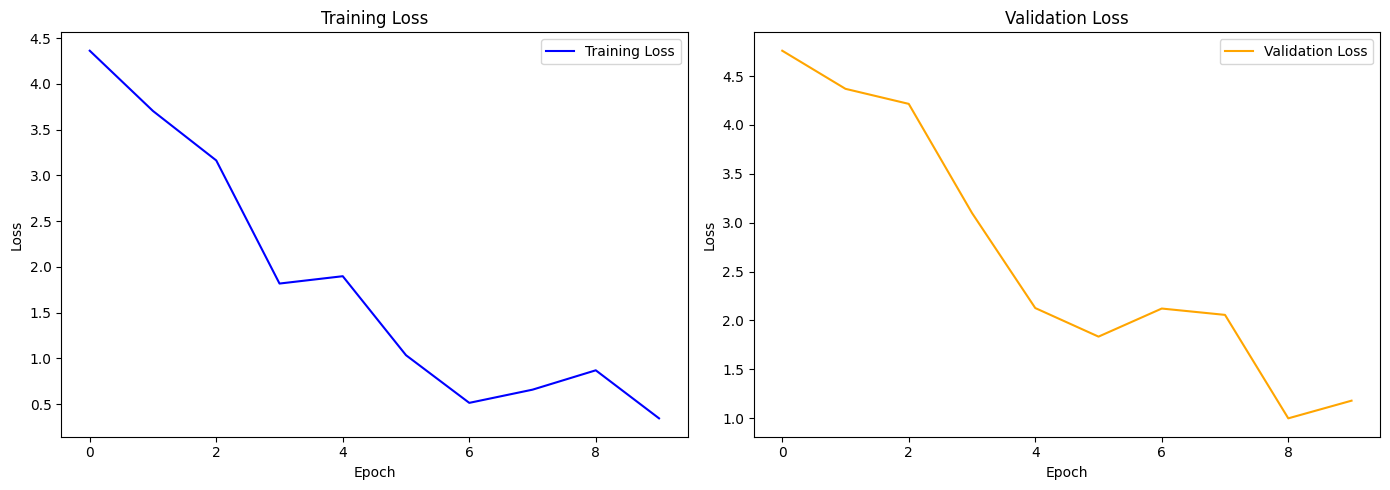

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

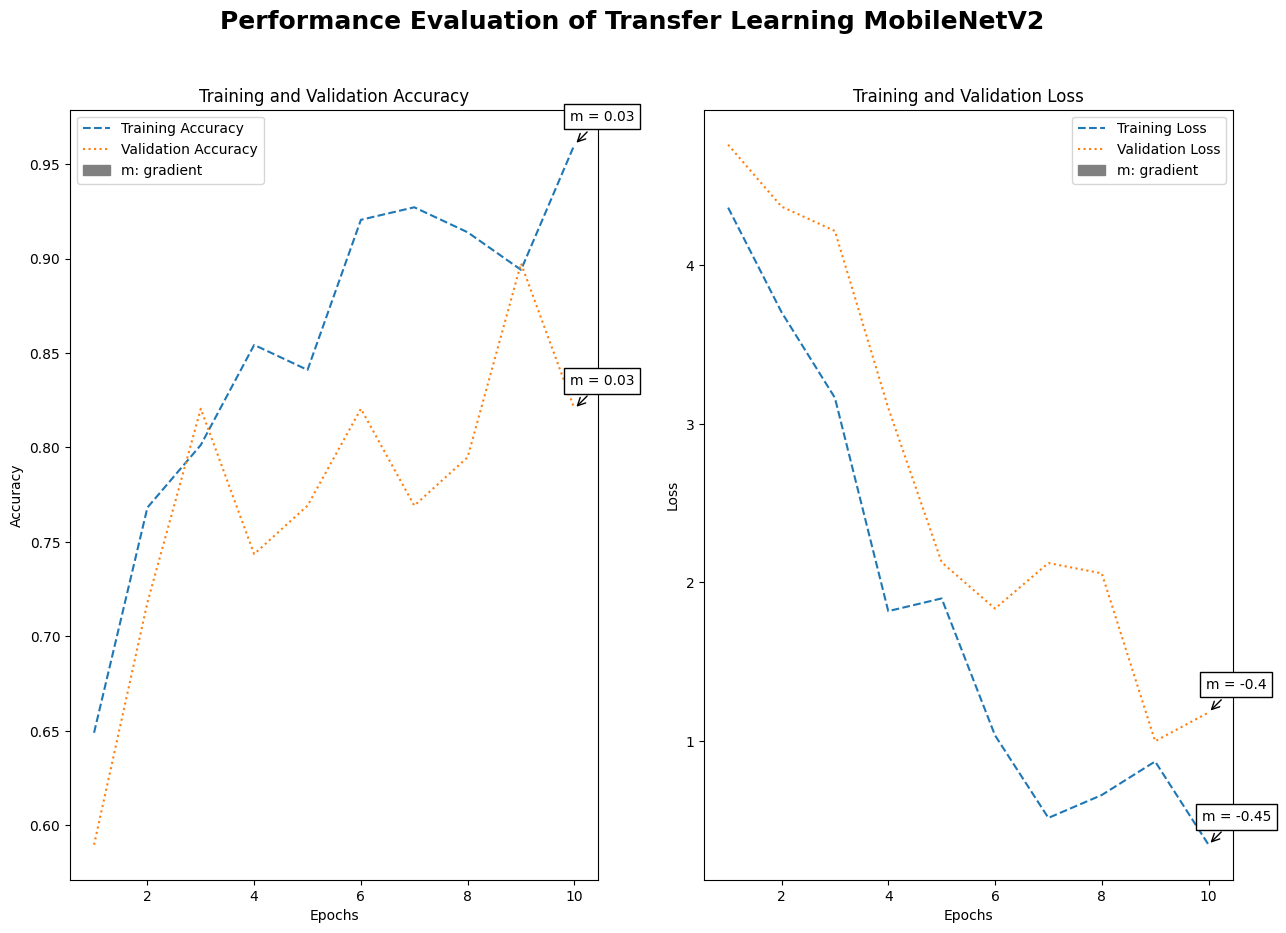

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, AnnotationBbox
import numpy as np

def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy']) + 1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)

        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)

    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

# Assuming you've already trained the model and have the history object
history_dict_1 = history.history
vis_evaluation(history_dict_1, 'Transfer Learning MobileNetV2')


In [ ]:
learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)

Epoch 1/150
1/3 [=========>....................] - ETA: 1:39 - loss: 1.4203 - accuracy: 0.3913

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 19s 19s/step


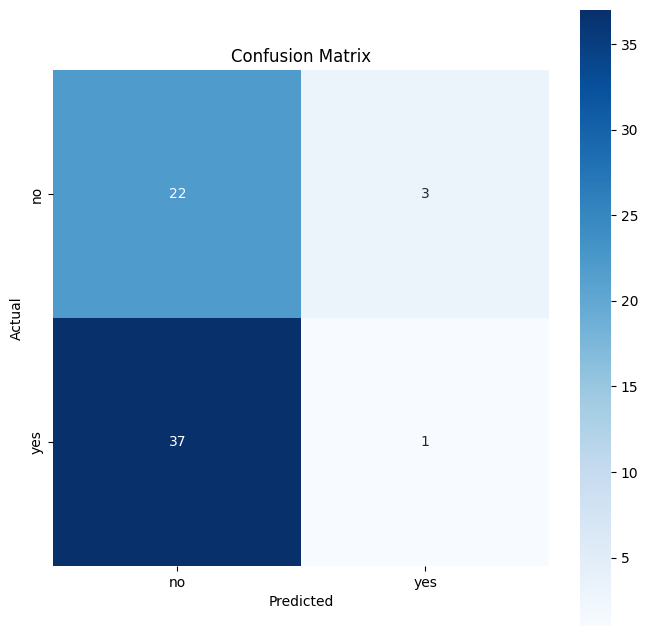

In [ ]:
# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()